# Credit Card Fraud Detection Analysis

This notebook implements credit card fraud detection using anomaly detection techniques.

## Overview
- We'll use two unsupervised learning algorithms: Isolation Forest and Local Outlier Factor (LOF)
- These techniques are effective for detecting outliers/anomalies in the data
- Credit card fraud detection is a classic application of anomaly detection

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, make_scorer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Import your existing utility module
import credit_card_fraud_utils as ccf





%matplotlib inline
plt.style.use('seaborn-v0_8') # Updated style name for compatibility

## 1. Setup and Configuration

In [2]:
# Initialize configuration
config = ccf.Config()

# You can modify config parameters here if needed
# config.IF_CONTAMINATION = 0.02
# config.LOF_N_NEIGHBORS = 25

# Display default configuration
print("Configuration Parameters:")
for attr, value in config.__dict__.items():
    print(f"{attr} = {value}")

Configuration Parameters:


## 2. Data Loading and Understanding

In [3]:
# Load the dataset
df = ccf.load_data(config)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"Number of Transactions: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Display the first few rows
df.head()

Dataset Shape: (284807, 31)
Number of Transactions: 284807
Number of Features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Get a summary of the dataset
summary = ccf.get_data_summary(df)

print(f"Missing Values: {summary['missing_values']}")
print(f"Normal Transactions: {summary['normal_count']} ({100 - summary['fraud_percentage']:.2f}%)")
print(f"Fraudulent Transactions: {summary['fraud_count']} ({summary['fraud_percentage']:.2f}%)")

# Based on the actual fraud percentage, we might want to update the contamination parameter
print(f"\nRecommended contamination value: {summary['fraud_percentage'] / 100:.6f}")
config.IF_CONTAMINATION = summary['fraud_percentage'] / 100
config.LOF_CONTAMINATION = summary['fraud_percentage'] / 100

Missing Values: 0
Normal Transactions: 284315 (99.83%)
Fraudulent Transactions: 492 (0.17%)

Recommended contamination value: 0.001727


## 3. Exploratory Data Analysis

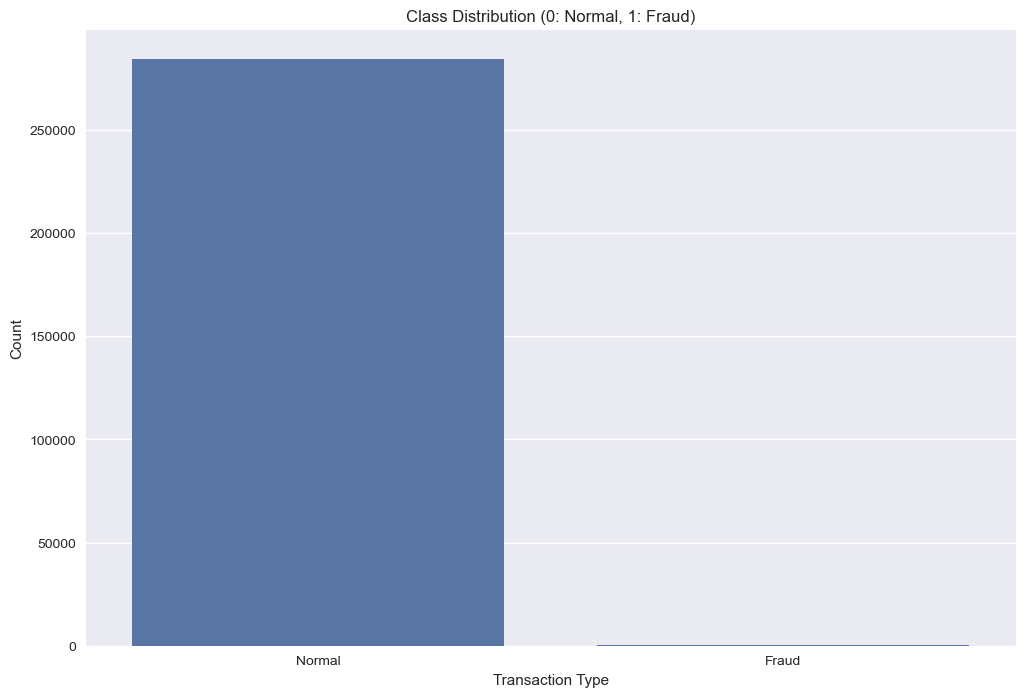

In [5]:
# Plot class distribution
plt_class = ccf.plot_class_distribution(df, config)
plt_class.show()

<Figure size 1200x800 with 0 Axes>

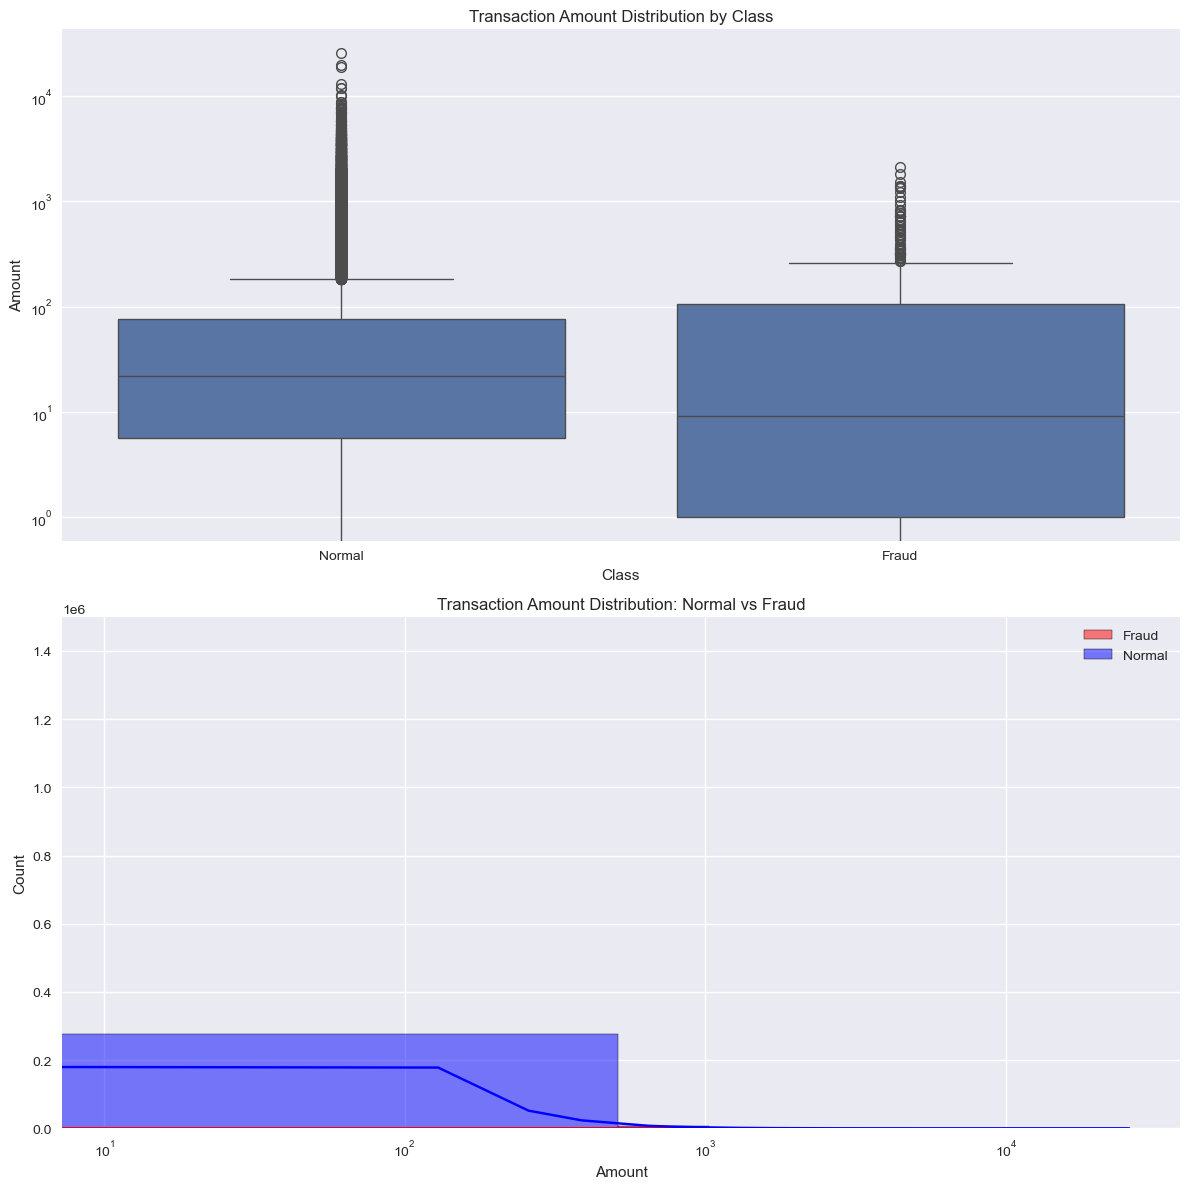

In [6]:
# Plot transaction amount distribution
plt_amount = ccf.plot_amount_distribution(df, config)
plt_amount.show()

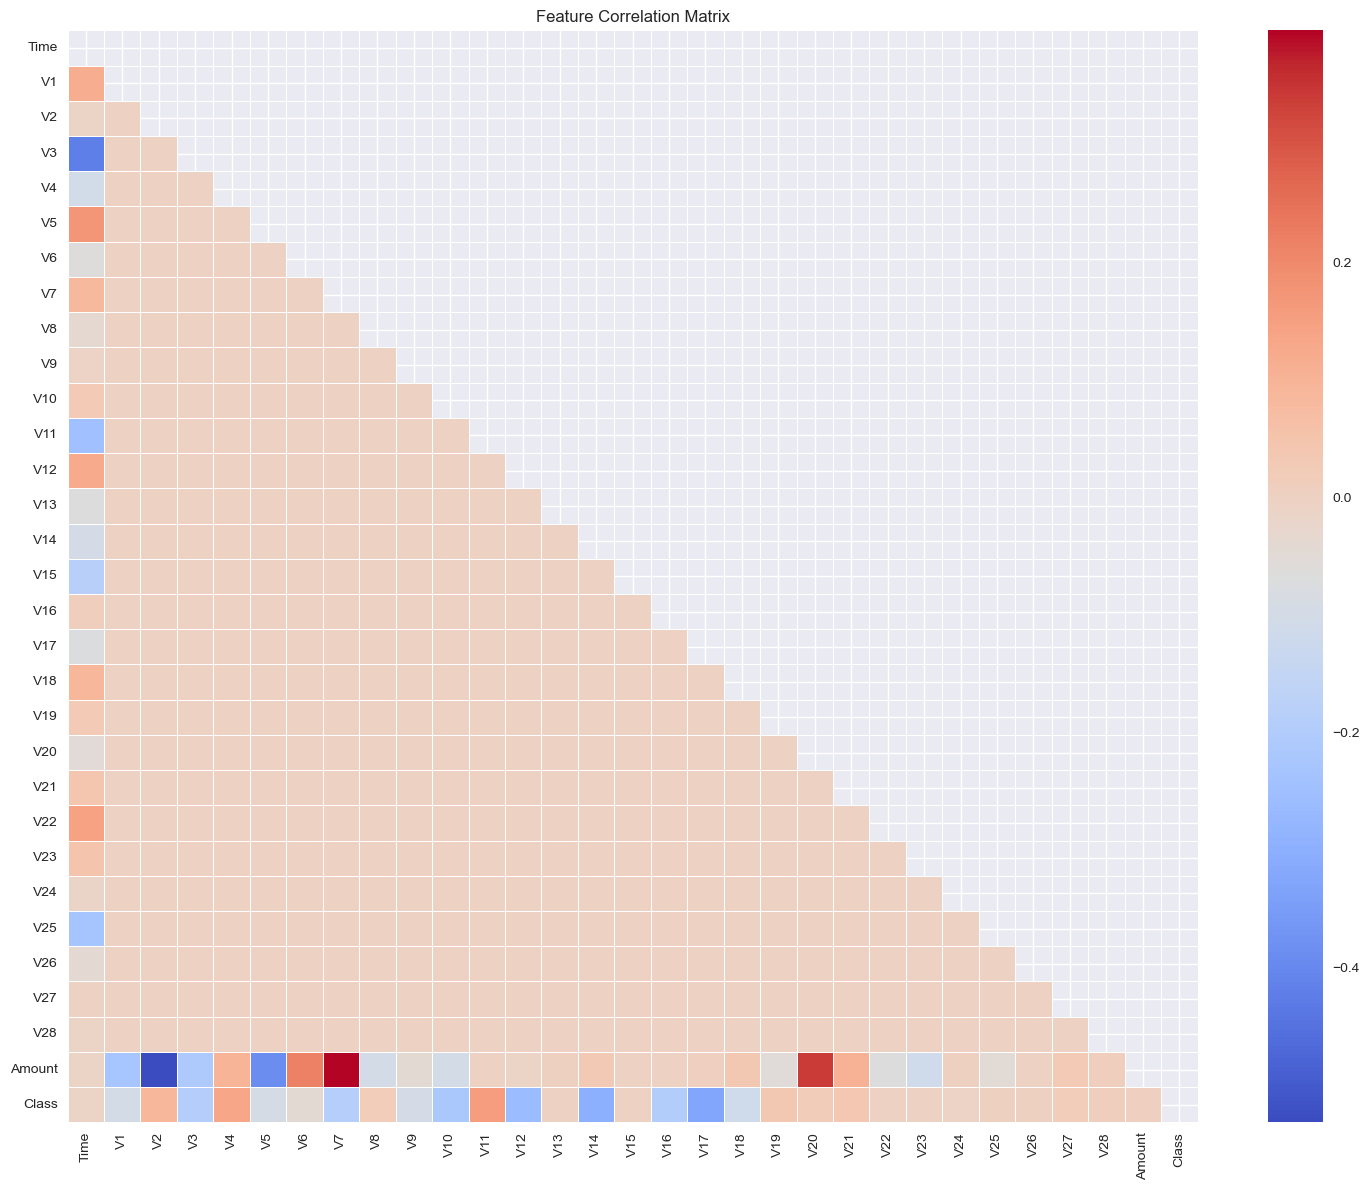

In [7]:
# Plot correlation matrix
plt_corr, corr_matrix = ccf.plot_correlation_matrix(df, config)
plt_corr.show()

Top 10 Features Correlated with Fraud:
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
Name: Class, dtype: float64


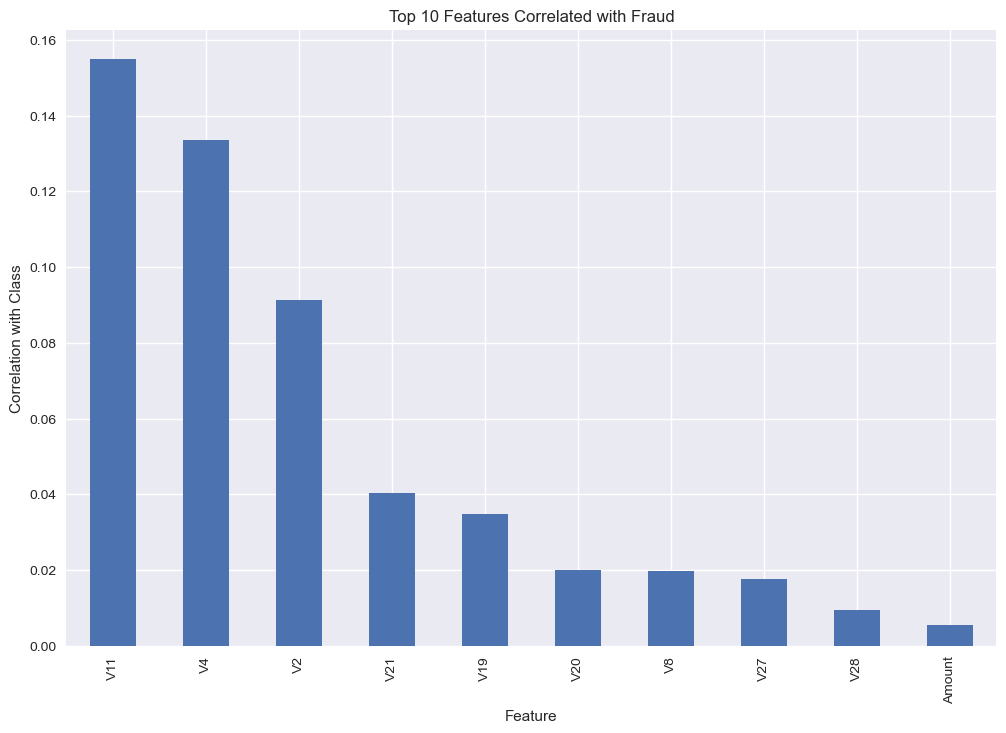

In [8]:
# Get top features correlated with fraud
top_correlations = ccf.get_top_correlations(corr_matrix, feature='Class', top_n=10)
print("Top 10 Features Correlated with Fraud:")
print(top_correlations)

# Visualize top correlations
plt.figure(figsize=config.FIGSIZE)
top_correlations.plot(kind='bar')
plt.title('Top 10 Features Correlated with Fraud')
plt.xlabel('Feature')
plt.ylabel('Correlation with Class')
plt.show()

## 4. Data Preprocessing

In [9]:
# Preprocess the data
X_train, X_test, y_train, y_test = ccf.preprocess_data(df, config)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set fraud percentage: {y_train.mean() * 100:.2f}%")
print(f"Testing set fraud percentage: {y_test.mean() * 100:.2f}%")

Training set shape: (227845, 30)
Testing set shape: (56962, 30)
Training set fraud percentage: 0.17%
Testing set fraud percentage: 0.17%


## 5. Handeling Imbalance

### Basline Model Logistic regression

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9988
Precision: 0.6786
Recall: 0.5816
F1-score: 0.6264
AUPRC: 0.6305


In [11]:
import all_metrics as all_metrics
y_pred_logistic = model.predict(X_test)


logistic_results = all_metrics.calculate_model_metrics(model, X_test, y_test, 'Logistic Regression')


Metrics for Logistic Regression:
Accuracy: 0.9988
Precision: 0.6786
Recall: 0.5816
F1-score: 0.6264
AUPRC: 0.4837
AUROC: 0.8729
Recall at 0.5% FPR: 0.6224
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.6276
Kolmogorov-Smirnov Statistic: 0.6471
Confusion Matrix:
[[56837    27]
 [   41    57]]


### Oversampling

In [12]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


oversample = RandomOverSampler(sampling_strategy='minority', random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(X_over, y_over)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9583
Precision: 0.0370
Recall: 0.9286
F1-score: 0.0712
AUPRC: 0.4829


In [13]:
oversample = RandomOverSampler(sampling_strategy=0.002, random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(X_over, y_over)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9987
Precision: 0.6429
Recall: 0.5510
F1-score: 0.5934
AUPRC: 0.5973


### Undersampling

In [14]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
X_under, y_under = undersample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(X_under, y_under)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")


Accuracy: 0.9580
Precision: 0.0367
Recall: 0.9286
F1-score: 0.0706
AUPRC: 0.4827


### Smote

In [15]:

oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)



model = LogisticRegression()
model.fit(Xsmote, ysmote)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9834
Precision: 0.0852
Recall: 0.8878
F1-score: 0.1555
AUPRC: 0.4866


## Baseline benchmark for resampling

SO far we can see that resampling with logistic regression does not really help

* **Recall at k% False Positive Rate (Recall @ k% FPR):** Businesses often have a tolerance limit for flagging legitimate transactions (FPR). For example, "We can tolerate investigating false alarms for 0.5% of our good transactions." You would then evaluate models based on how much fraud they catch (Recall) *at that specific, acceptable FPR level*. This directly links model performance to operational constraints.

* **Precision at k Recall:** Conversely, if the priority is to catch a certain percentage of all fraud (e.g., 90% Recall), you'd evaluate models based on how precise they are (how many flagged transactions are *actually* fraud) at that required Recall level.

* **Matthews Correlation Coefficient (MCC):** This is a robust metric for imbalanced binary classification that considers all four confusion matrix values (TP, TN, FP, FN). It ranges from -1 (total disagreement) to +1 (perfect prediction), with 0 being random guessing. It's often considered more informative than F1 when classes are very imbalanced. MCC = (TP×TN - FP×FN)/√[(TP+FP)(TP+FN)(TN+FP)(TN+FN)]

* **Kolmogorov-Smirnov (KS) Statistic:** Measures the maximum separation between the score distributions of the positive (fraud) and negative (normal) classes. A higher KS statistic indicates a better ability of the model to distinguish between fraud and non-fraud transactions based on its output score.

## Compare logistic_reg, XGBoost, Random Forest

### Logistic regression

In [17]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

pipeline = Pipeline([
    ('scaler', StandardScaler()), # ADD SCALER!
    ('resampler', None),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])


param_grid = [
    { # Configuration for SMOTE
        'resampler': [SMOTE(random_state=42)],
        'resampler__k_neighbors': [3, 5, 7], # Example SMOTE parameter
        'resampler__sampling_strategy': [0.5, 0.7, 0.9],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    { # Configuration for RandomOverSampler
        'resampler': [RandomOverSampler(random_state=42)],
        # ROS doesn't have many tunable params, maybe sampling_strategy if needed
        'classifier__C': [0.01, 0.1, 1, 10],
        'resampler__sampling_strategy': [0.5, 0.7, 0.9],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    { # Configuration for RandomUnderSampler
        'resampler': [RandomUnderSampler(random_state=42)],
        'classifier__C': [0.01, 0.1, 1, 10],
        'resampler__sampling_strategy': [0.5, 0.7, 0.9],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    { # Configuration for ADASYN
        'resampler': [ADASYN(random_state=42)],
        'resampler__n_neighbors': [3, 5, 7],
        'resampler__sampling_strategy': [0.5, 0.7, 0.9],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    { # Configuration for TomekLinks
        'resampler': [TomekLinks()],
        'classifier__C': [0.01, 0.1, 1, 10],
        'resampler__sampling_strategy': [0.4,0.5, 0.7, 0.9],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    { # Configuration for NearMiss
        'resampler': [NearMiss()],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
     { # Configuration for NO resampling (baseline)
        'resampler': [None],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    }
]

# Use GridSearchCV with the pipeline and param_grid
grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_iter=50, verbose=1, n_jobs=-1) 
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'resampler': None, 'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 0.1}
0.7208093446342116


In [18]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampler__sampling_strategy,param_resampler__n_neighbors,param_resampler,param_classifier__solver,param_classifier__penalty,param_classifier__C,param_resampler__k_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,1.540613,0.076035,0.017895,0.006724,NaN,NaN,None,liblinear,l2,0.10,NaN,"{'resampler': None, 'classifier__solver': 'lib...",0.751880,0.703125,0.716418,0.666667,0.765957,0.720809,0.035404,1
26,3.400302,0.359946,0.015141,0.003693,0.5,NaN,RandomOverSampler(random_state=42),liblinear,l2,0.10,NaN,"{'resampler__sampling_strategy': 0.5, 'resampl...",0.206897,0.226415,0.217532,0.225225,0.214182,0.218050,0.007226,2
8,0.122850,0.011380,0.017683,0.006312,0.5,NaN,RandomUnderSampler(random_state=42),liblinear,l1,0.10,NaN,"{'resampler__sampling_strategy': 0.5, 'resampl...",0.212833,0.203077,0.185596,0.236629,0.207681,0.209163,0.016508,3
21,3.311312,0.417215,0.020303,0.006098,0.5,NaN,SMOTE(random_state=42),liblinear,l2,10.00,3.0,"{'resampler__sampling_strategy': 0.5, 'resampl...",0.194915,0.215334,0.205207,0.209929,0.207865,0.206650,0.006744,4
1,5.578959,0.616450,0.044081,0.020129,0.5,NaN,SMOTE(random_state=42),liblinear,l1,0.01,7.0,"{'resampler__sampling_strategy': 0.5, 'resampl...",0.188525,0.211538,0.196481,0.223228,0.203857,0.204726,0.012000,5
48,13.317416,2.928472,0.027701,0.005316,0.5,NaN,SMOTE(random_state=42),liblinear,l1,10.00,7.0,"{'resampler__sampling_strategy': 0.5, 'resampl...",0.185734,0.208531,0.194203,0.209040,0.198126,0.199127,0.008847,6
6,13.857946,4.628410,0.027100,0.009978,0.5,NaN,SMOTE(random_state=42),liblinear,l1,1.00,7.0,"{'resampler__sampling_strategy': 0.5, 'resampl...",0.185734,0.207874,0.194203,0.209040,0.197861,0.198942,0.008716,7
27,3.608737,0.237926,0.017498,0.005435,0.7,NaN,RandomOverSampler(random_state=42),liblinear,l2,0.10,NaN,"{'resampler__sampling_strategy': 0.7, 'resampl...",0.158257,0.177955,0.148559,0.162338,0.162514,0.161924,0.009482,8
17,12.952689,5.032452,0.029672,0.002949,0.7,NaN,RandomOverSampler(random_state=42),liblinear,l1,0.10,NaN,"{'resampler__sampling_strategy': 0.7, 'resampl...",0.158257,0.177249,0.148724,0.162338,0.161987,0.161711,0.009192,9
49,12.868382,4.200182,0.012119,0.005038,0.7,NaN,RandomOverSampler(random_state=42),liblinear,l1,10.00,NaN,"{'resampler__sampling_strategy': 0.7, 'resampl...",0.157175,0.177719,0.147740,0.161117,0.162690,0.161288,0.009720,10


In [19]:

import all_metrics as all_metrics



#oversample = SMOTE(k_neighbors=3, random_state=42)
oversample = TomekLinks()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)


model_logistic = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', random_state=42, max_iter=1000)
model_logistic.fit(Xsmote, ysmote)
y_pred_logistic = model_logistic.predict(X_test)


logistic_results = all_metrics.calculate_model_metrics(model_logistic, X_test, y_test, 'Logistic Regression')


Metrics for Logistic Regression:
Accuracy: 0.9988
Precision: 0.7213
Recall: 0.4490
F1-score: 0.5535
AUPRC: 0.4572
AUROC: 0.8947
Recall at 0.5% FPR: 0.5816
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.5685
Kolmogorov-Smirnov Statistic: 0.6609
Confusion Matrix:
[[56847    17]
 [   54    44]]


In [20]:
import all_metrics as all_metrics
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler # Make sure StandardScaler is imported
import numpy as np # Often needed



# --- Original Manual Block (Rank 1 - TomekLinks, Manual, NO SCALING) ---
# WARNING: This block likely gives different results than using the
#       pipeline's best_estimator_ because it lacks the StandardScaler step
#       that was part of the winning pipeline during the search.
print("\n--- Evaluating Rank 1 Manually (TomekLinks, C=0.01, NO SCALING - FOR REFERENCE ONLY) ---")
oversample_tomek = TomekLinks(sampling_strategy='auto') # Specify strategy if needed, 'auto' is default
# Resample original (unscaled) X_train
# Use try-except as TomekLinks can sometimes fail if no links are found
try:
    X_tomek, y_tomek = oversample_tomek.fit_resample(X_train, y_train)
    print(f"Shape after TomekLinks: {X_tomek.shape}")

    model_logistic_tomek_manual = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', random_state=42, max_iter=1000)
    # Fit on resampled, unscaled data
    model_logistic_tomek_manual.fit(X_tomek, y_tomek)
    # Evaluate on original (unscaled) X_test
    logistic_results_tomek_manual = all_metrics.calculate_model_metrics(
        model_logistic_tomek_manual, X_test, y_test, 'Manual TomekLinks (No Scaling)'
    )
except ValueError as e:
    print(f"TomekLinks resampling failed: {e}")
    print("Skipping manual TomekLinks evaluation.")
print("-" * 50)


# --- ADDED: Manual Evaluation for Rank 2 (No Resampling, SCALED, C=0.01) ---
print("\n--- Evaluating Rank 2 Manually (No Resampling, SCALED, C=0.01) ---")

# 1. Initialize and Fit Scaler
scaler = StandardScaler()
# Fit the scaler ONLY on the original training data
scaler.fit(X_train)

# 2. Scale Training and Test Data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same fitted scaler

# 3. Define the Rank 2 Model
#    (No resampling step needed)
model_logistic_rank2 = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', random_state=42, max_iter=1000)

# 4. Train the Model on Scaled Training Data
model_logistic_rank2.fit(X_train_scaled, y_train) # Fit on scaled X_train, original y_train

# 5. Evaluate the Model on Scaled Test Data
logistic_results_rank2 = all_metrics.calculate_model_metrics(
    model_logistic_rank2, X_test_scaled, y_test, 'Logistic Regression (Rank 2: No Resampling, Scaled, C=0.01)'
)
print("-" * 50)



print("\n--- Evaluating Scaled Baseline Manually (No Resampling, SCALED, Default Params) ---")

# 1. Use the same scaled data (X_train_scaled, X_test_scaled) from above

# 2. Define the Model with default parameters
model_logistic_scaled_baseline = LogisticRegression(random_state=42, max_iter=1000) # Default C=1.0 etc.

# 3. Train the Model on Scaled Training Data
model_logistic_scaled_baseline.fit(X_train_scaled, y_train)

# 4. Evaluate the Model on Scaled Test Data
logistic_results_scaled_baseline = all_metrics.calculate_model_metrics(
    model_logistic_scaled_baseline, X_test_scaled, y_test, 'Logistic Regression (Scaled Baseline, Default Params)'
)
print("-" * 50)



--- Evaluating Rank 1 Manually (TomekLinks, C=0.01, NO SCALING - FOR REFERENCE ONLY) ---
Shape after TomekLinks: (227781, 30)

Metrics for Manual TomekLinks (No Scaling):
Accuracy: 0.9988
Precision: 0.7213
Recall: 0.4490
F1-score: 0.5535
AUPRC: 0.4572
AUROC: 0.8947
Recall at 0.5% FPR: 0.5816
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.5685
Kolmogorov-Smirnov Statistic: 0.6609
Confusion Matrix:
[[56847    17]
 [   54    44]]
--------------------------------------------------

--- Evaluating Rank 2 Manually (No Resampling, SCALED, C=0.01) ---

Metrics for Logistic Regression (Rank 2: No Resampling, Scaled, C=0.01):
Accuracy: 0.9991
Precision: 0.8615
Recall: 0.5714
F1-score: 0.6871
AUPRC: 0.7570
AUROC: 0.9781
Recall at 0.5% FPR: 0.8469
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.7012
Kolmogorov-Smirnov Statistic: 0.9113
Confusion Matrix:
[[56855     9]
 [   42    56]]
--------------------------------------------------

--- Evaluating Scal

In [21]:
import all_metrics as all_metrics # Your custom metrics function
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# Assuming X_train, y_train, X_test, y_test are available

print("\n--- Evaluating Candidate from F1-Optimized CV (No Resampling, L1, C=1.0) ---")

# Define the pipeline matching Rank 1 params from the F1-optimized search
# ASSUMES StandardScaler was used in the pipeline for that search
pipeline_f1_rank1 = Pipeline([
    ('scaler', StandardScaler()),
    ('resampler', None),
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1', C=1.0,
                                      random_state=42, max_iter=1000))
])

# Fit this pipeline on the original training data
pipeline_f1_rank1.fit(X_train, y_train)

# Evaluate on the test set using your metrics function
results_f1_rank1 = all_metrics.calculate_model_metrics(
    pipeline_f1_rank1, X_test, y_test, 'Logistic Regression (F1 CV Rank 1: No Resampling, L1, C=1.0)'
)

# --- Compare Test F1 Scores ---
# F1 Score from this run: results_f1_rank1['F1-score'] (or however your function returns it)
# F1 Score from previous best (Rank 2 from ROC AUC search): 0.6871
print("\nComparison of Test F1-Scores:")
print("  F1-Optimized CV Rank 1 (L1, C=1.0): {}".format(results_f1_rank1.get('F1-score', 'N/A')))
print("  ROC AUC-Optimized CV Rank 2 (L2, C=0.01): 0.6871")


--- Evaluating Candidate from F1-Optimized CV (No Resampling, L1, C=1.0) ---

Metrics for Logistic Regression (F1 CV Rank 1: No Resampling, L1, C=1.0):
Accuracy: 0.9991
Precision: 0.8636
Recall: 0.5816
F1-score: 0.6951
AUPRC: 0.7573
AUROC: 0.9750
Recall at 0.5% FPR: 0.8776
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.7084
Kolmogorov-Smirnov Statistic: 0.9090
Confusion Matrix:
[[56855     9]
 [   41    57]]

Comparison of Test F1-Scores:
  F1-Optimized CV Rank 1 (L1, C=1.0): N/A
  ROC AUC-Optimized CV Rank 2 (L2, C=0.01): 0.6871


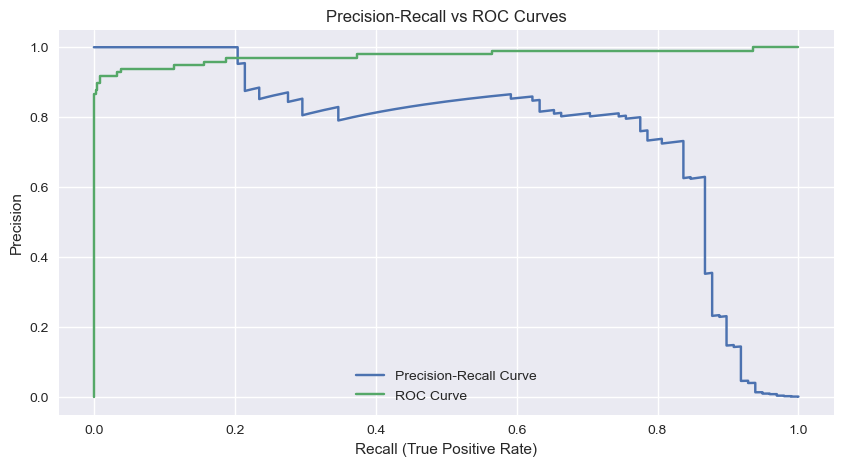

In [22]:
# Get predicted probabilities for the positive class (fraud)
y_scores = pipeline_f1_rank1.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# Get binary predictions for metrics
y_pred = pipeline_f1_rank1.predict(X_test)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

So for Logistic regression the best model so far is 

- Preprocessing: StandardScaler
- Resampling: None
- Model: LogisticRegression(solver='liblinear', penalty='l1', C=1.0, random_state=42, max_iter=1000)

we could do a more extensive search using gridsearch but its going to be computationally expensive